# Exploring credit card charges and fraud probability. 

## Goals for this Data Set
* Understand and distribute the data given to us
* Create a sub-frame of Fraud and Non-Fraud split 50/50
* Find which Classifier gives us the highest accuracy.
* Avoid Common mistakes with an imbalanced dataset and how to avoid them. 

In [4]:
#Credit Card Fraud. 
#import statements
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

#Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

#Our Dataset is imbalanced so we have to adjust for that as we import. 
#Some libraries have specialty imports for imbalanced. 

from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings

## Data Wrangling and importing the csv
For our Dataset we don't have todo much wrangling, if you take a look at df.head() you'll see that our data set is already clean. 

In [5]:
data_path = '../creditcard.csv/creditcard.csv'
#create wrangle path. 
def wrangle(df_path):
    df = pd.read_csv(df_path)
    
    return df

In [6]:
df = wrangle(data_path)

In [7]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Lets see if we have any missing values

In [9]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Here our data seems clean and orderly, we are missing no values but our data has been Transformed to [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) (Dimensionality Reduction Technique). Which means our data is Scalled and Unified our Columns names are hidden. None the less we can still create a good predictive model for fraud with out needing exact information. 

Unfortunatly our data set does have one glaring problem. *it's Heavily imbalanced.*

In [10]:

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')


No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


If we were to run our predictive models on this we would have a very overfit model and our baseline would be 99% accurate. great for the quick overview of the bosses but not so much for any predictions. 

There are a few ways to clean this imbalanced dataset and make a subset of the data frame we can actually use. For our needs we'll need to create a dataset that has a 50/50 split

### Scaled Data and Split Data
Our data set was scalled via PCA to have its data anomilized and scaleed to help reduce outliers. However if we look at our head values specifically df['Amount'] and df['Time'] These values were not scaled to match our data. Lets take a look at those distributions and see what information we can gain

In [11]:
print(df['Amount'].head())
print(df['Time'].head())

0    149.62
1      2.69
2    378.66
3    123.50
4     69.99
Name: Amount, dtype: float64
0    0.0
1    0.0
2    1.0
3    1.0
4    2.0
Name: Time, dtype: float64


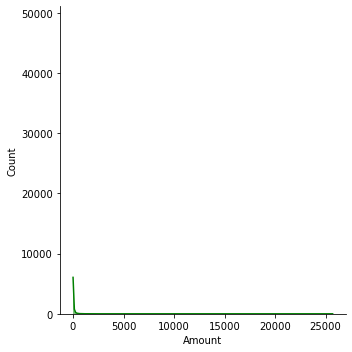

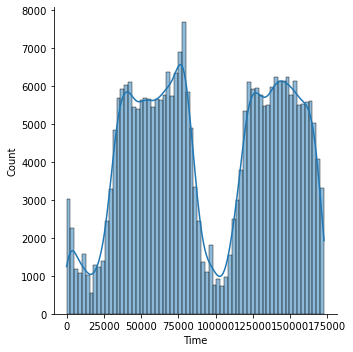

In [12]:

#create amount sub plot.
sns.displot(data = df,x = 'Amount',kde = True,color = 'g')

 


#create time sub-plot

sns.displot(data = df,x = 'Time',kde=True)



These values are all over the place, and would be hard to use if not scalled to our PCA values. 

In [13]:
#Scaling time and ammount using rob scale

#Rob_scaler is a scale feature using stats that are ROBust to Outliers

from sklearn.preprocessing import StandardScaler, RobustScaler

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

# we now want to put our scalled time and amount at the front of our df and drop the old columns to avoid confusion
df = df.drop(['Time','Amount'],axis=1)


In [14]:

scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df = df.drop(['scaled_amount','scaled_time'],axis=1)
df.insert(0,'scaled_amount',scaled_amount)
df.insert(1,'scaled_time',scaled_time)

In [15]:
df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


Now we have to create our 50/50 data so that we can begin probability testing using a new splitter [StratifiedShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html)

In [16]:
#new import statements 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
#first we create our feature variable and our X
target = 'Class'
X = df.drop(target,axis=1)
y = df[target]


sss = StratifiedKFold(n_splits=5,random_state=None,shuffle=False)

for train_index,test_index in sss.split(X,y):
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

In [17]:
#fraction of axis to return

df = df.sample(frac=1)

fraud_df = df.loc[df['Class']==1]
no_fraud_df = df.loc[df['Class']==0][:len(fraud_df)]
print(len(fraud_df))
print(len(no_fraud_df))

normal_dist_df = pd.concat([fraud_df, no_fraud_df])

samp_df = normal_dist_df.sample(frac=1,random_state=42)
samp_df.head()

492
492


,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
124921,-0.275554,-0.084822,-0.648157,1.021751,1.612949,-0.165162,0.105704,-0.213897,0.543442,0.148528,...,0.072631,-0.115562,-0.297450,0.048293,0.213735,-0.316914,0.057812,0.148336,0.104386,0
68522,-0.296793,-0.371962,0.206075,1.387360,-1.045287,4.228686,-1.647549,-0.180897,-2.943678,0.859156,...,0.351484,0.469199,0.344930,-0.203799,0.376640,0.715485,0.226003,0.628545,0.319918,1
84603,3.654021,-0.285565,0.585405,-1.001495,0.881673,1.585707,-1.151642,0.271417,-0.354159,0.205657,...,0.317201,0.304990,0.395444,-0.288520,0.069234,0.287207,-0.237834,0.023448,0.078104,0
261925,1.872424,0.887593,-2.783865,1.596824,-2.084844,2.512986,-1.446749,-0.828496,-0.732262,-0.203329,...,-0.515001,0.203563,0.293268,0.199568,0.146868,0.163602,-0.624085,-1.333100,0.428634,1
249828,-0.213233,0.821285,0.667714,3.041502,-5.845112,5.967587,0.213863,-1.462923,-2.688761,0.677764,...,0.558425,0.329760,-0.941383,-0.006075,-0.958925,0.239298,-0.067356,0.821048,0.426175,1


Lets test the distribution


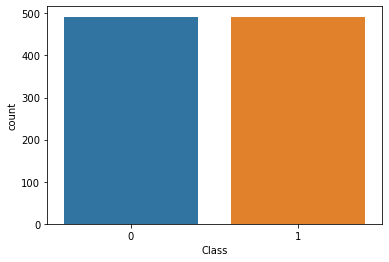

In [18]:
sns.countplot(data=samp_df, x = 'Class')
plt.show()

So now we have a 50/50 distributed subset given this we have to now take a look and find out which of our columns have Correlation to our class outcome. 


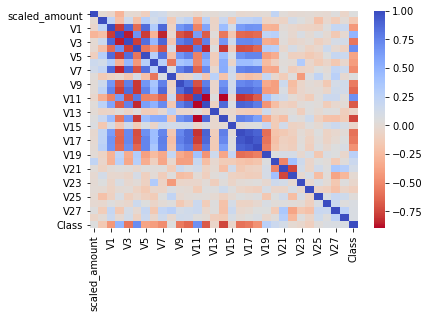

In [19]:
sub_samp_corr = samp_df.corr()

sns.heatmap(sub_samp_corr,cmap='coolwarm_r',annot_kws={'size':20})
plt.show()

##### Negative Correlations: V17, V14, V12 and V10 are negatively correlated. Notice how the lower these values are, the more likely the end result will be a fraud transaction.

##### Positive Correlations: V2, V4, V11, and V19 are positively correlated. Notice how the higher these values are, the more likely the end result will be a fraud transaction. 

## Classifiers and you, A journey though time. 
With undersampling we have to determin which of our classifiers will be the most accurate with our subset of data. 

### Remember

* The wider the gap between the training score and the cross validation score, the more likely your model is overfitting (high variance).
* If the score is low in both training and cross-validation sets this is an indication that our model is underfitting (high bias)
* Logistic Regression Classifier shows the best score in both training and cross-validating sets.



In [20]:
X= samp_df.drop('Class',axis=1)
y = samp_df['Class']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#we turn the values into an array for our loop.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [25]:

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    'RandomForest':RandomForestClassifier()
}

In [26]:
from sklearn.model_selection import cross_val_score
#for loop to iterate and get the scores for each classifier to determin the best fit. 
#from our data we can say the Logistric Regression is the best fit.
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 95.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 94.0 % accuracy score
Classifiers:  SVC Has a training score of 94.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 92.0 % accuracy score
Classifiers:  RandomForestClassifier Has a training score of 94.0 % accuracy score


In [42]:
#from imblearn.over_sampling import SMOTEN
#sampler = SMOTEN(sampling_strategy='minority',random_state=0)
#X_res,y_res = sampler.fit_resample(X,y)

